<a href="https://colab.research.google.com/github/juanxo90/cargamos/blob/main/cargamos_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba técnica para la posición de data science en Cargamos



In [1]:
# importamos las librerias
import pandas as pd
import plotly.express as px

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
pd.set_option("display.max_columns", None)

# cargamos los datos
paq_det = pd.read_csv("https://raw.githubusercontent.com/juanxo90/cargamos/main/data/paquete_clean.csv")
reg_det = pd.read_csv("https://raw.githubusercontent.com/juanxo90/cargamos/main/data/register_clean.csv")

In [3]:
paq_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14056 entries, 0 to 14055
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id_paquete        14056 non-null  object
 1   cedis             14056 non-null  object
 2   estado            14056 non-null  object
 3   hora_recolectado  13997 non-null  object
 4   hora_creacion     14056 non-null  object
 5   hora_entrega      12502 non-null  object
 6   hora_falla        1651 non-null   object
dtypes: object(7)
memory usage: 768.8+ KB


In [4]:
reg_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15573 entries, 0 to 15572
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id_paquete          15573 non-null  object
 1   id_monitoreo        15573 non-null  object
 2   arreglo_estado      15573 non-null  object
 3   complemento_estado  15236 non-null  object
 4   fecha_creado        15573 non-null  object
dtypes: object(5)
memory usage: 608.4+ KB


In [5]:
df = reg_det.merge(paq_det, how="inner", on=["id_paquete"])

In [6]:
grouped = df[["arreglo_estado", "complemento_estado", "estado"]].groupby(["arreglo_estado", "complemento_estado", "estado"])["estado"].count()
grouped = pd.DataFrame(grouped)
grouped = grouped.rename(columns={'estado': 'conteo'})
grouped.reset_index(inplace=True)

In [9]:
fig = px.bar(grouped[grouped.complemento_estado == "DELIVERY_ATTEMPTED"], x='estado', y='arreglo_estado')
fig.show()

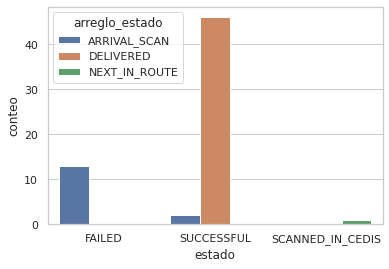

In [16]:
# g = sns.catplot(x="estado", y="conteo",
#                 col="complemeto_estado", hue = "arreglo_estado",
#                 data=grouped, kind="bar",
#                 dodge=True).set(yscale ='log')

sns.barplot(x="estado", y="conteo", hue = "arreglo_estado",
            data=grouped[grouped.complemento_estado == "DELIVERY_ATTEMPTED"])

In [14]:
grouped.complemento_estado.unique()

array(['DELIVERY_ATTEMPTED', 'ORIGIN_SCAN', 'RETURNED_TO_CLIENT'],
      dtype=object)